### **前置處理**

1. 匯入套件

In [1]:
import pandas as pd # 載入pandas 套件 重新命名引用名稱:pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns     #套件名，並rename
import plotly.express as px
import warnings
warnings.simplefilter("ignore")

2. 讀取資料檔案

In [2]:
diabetes = pd.read_csv('./diabetes.csv')  # 讀入csv檔，並把資料命名為 'rowdata'(./為同一資料夾)
diabetes.head(10) # show出前10筆資料，從0開始

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


3. 查看資料型態

In [3]:
diabetes.dtypes #查看資料集內的特徵資料型態(因為資料型態不同會有不同處理方式)

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

4. 查看資料筆數

In [4]:
diabetes.groupby('Outcome').size()

Outcome
0    500
1    268
dtype: int64

Text(0.5, 1.0, 'Outcome')

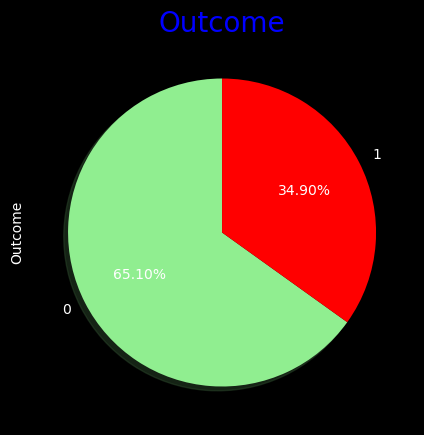

In [5]:
# 畫圖
colors = ["lightgreen", "red"]
diabetes["Outcome"].value_counts().plot(
    kind="pie", #圖形類別: 圓餅圖
    shadow=True, #圓餅圖要不要有陰影
    startangle=90,#設定圓餅圖角度
    figsize=(5, 5),#設定圖形的大小
    autopct="%1.2f%%",
    colors=colors,
)
plt.title("Outcome", fontsize=20, color="blue")

=>  可看出 Outcome=0 和 Outcome=1 之值相加為100%, Outcome沒有輸入失誤的資料, 不須改動

5. 檢查數值特徵分佈

In [6]:
#紀錄資料型態不是object的數量
num_cols = [col for col in diabetes.columns if diabetes[col].dtype != 'object'] 

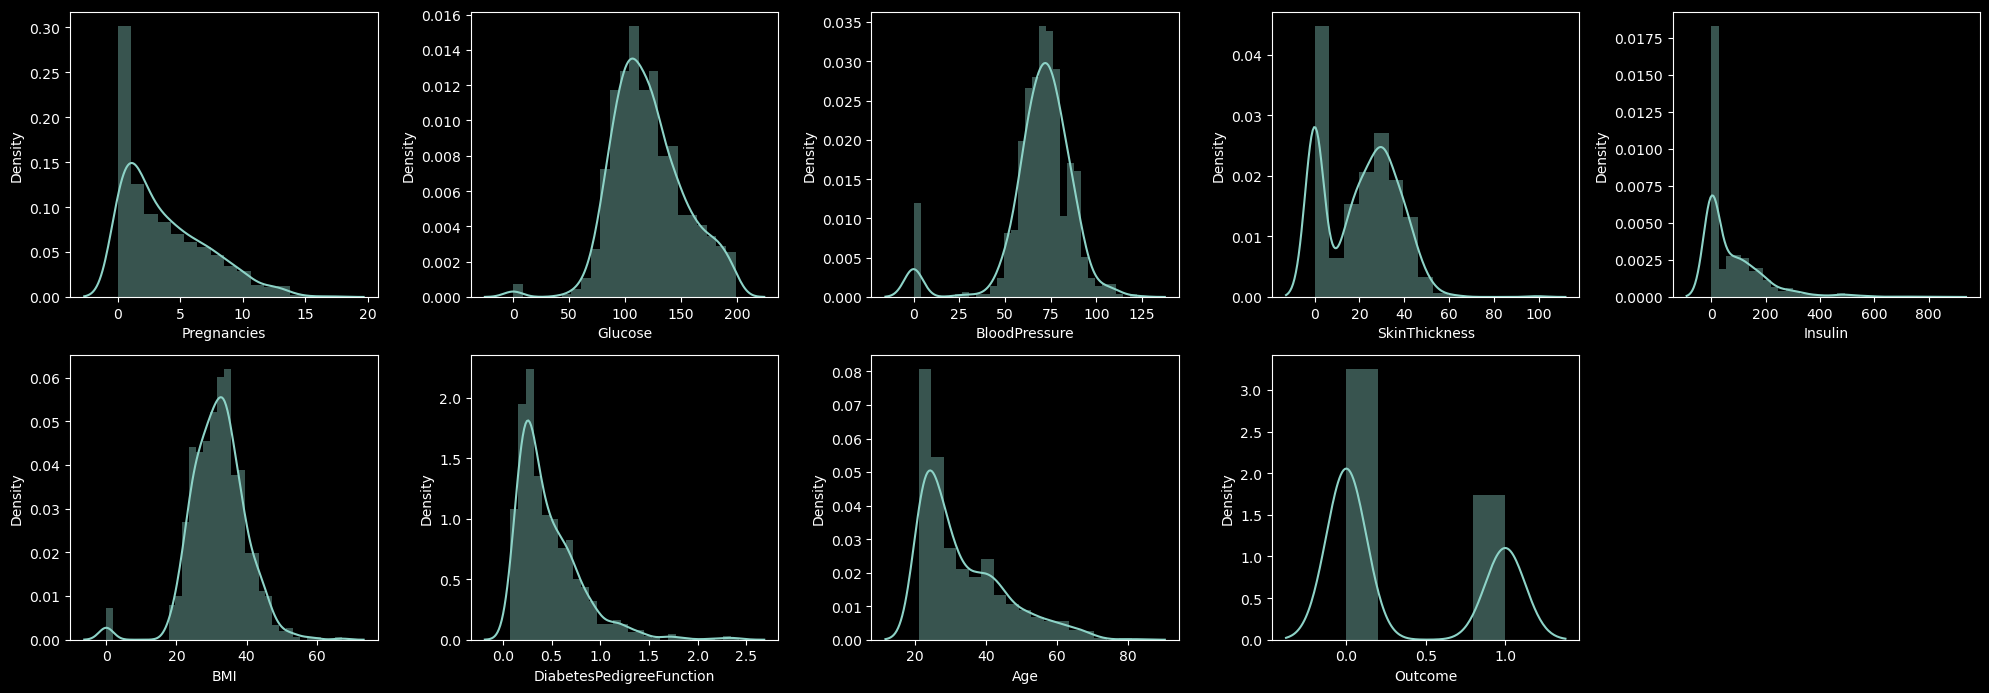

In [7]:
plt.figure(figsize = (20,10))
plot_number = 1

for column in num_cols:
    if plot_number <= 14:
        ax = plt.subplot(3, 5, plot_number)
        sns.distplot(diabetes[column])
        plt.xlabel(column)
        
    plot_number += 1

plt.tight_layout()
plt.show()

6. 特徵工程

=> 因為特徵中的 BloodPressure(血壓)、BMI、Glucose(血糖)不可能為0，故把為0的資料去除

In [8]:
#去除血壓、BMI、血糖為0的資料
diabetes_mod = diabetes[(diabetes.BloodPressure != 0) & (diabetes.BMI != 0) & (diabetes.Glucose != 0)]
#檢查剩餘資料數量 (724筆)
print(diabetes_mod.shape)

(724, 9)


In [9]:
# 校正資料型態 (要把資料型態校正回正確的資料型態)
diabetes_mod.dtypes # 查看整份資料所有欄位資料型態

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

=> 檢查資料型態過後，發現column的資料型態皆正確，故不須更改

7. 區分**特徵欄位**與**預測目標欄位**:

In [10]:
# 將移除 Outcome(預測目標)的剩餘欄位命名為 x_features
x_features = diabetes_mod.drop('Outcome',axis=1)

#將 Outcome(預測目標)欄位命名為 y_label
y_label = diabetes_mod['Outcome']

### **模型開發**

1. 切分資料集

In [11]:
#使用 k-fold 來做
from sklearn.model_selection import KFold

In [12]:
#定義 k折交叉驗證 (使用k-fold)
kf = KFold(n_splits=5, shuffle=True, random_state=42) #sample random 成5份

2. 選擇模型 - 比較7種不同模型

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [14]:
#依序比較7種不同模型
for name in ( 'KNeighborsClassifier', 'SVC','LogisticRegression', 'DecisionTreeClassifier',
    'GaussianNB', 'RandomForestClassifier', 'GradientBoostingClassifier'):
    
    #執行 k-fold 交叉驗證
    model = globals()[name]()
    test_bias = []
    test_variance = []
    train_errors = []
    test_errors = []

    for train_index, test_index in kf.split(x_features):

        #拆分數據集為訓練集和測試集
        x_train, y_train = x_features.iloc[train_index], y_label.iloc[train_index]
        x_test, y_test = x_features.iloc[test_index], y_label.iloc[test_index]

        #訓練模型
        model.fit(x_train, y_train)

        y_train_pred = model.predict(x_train) #預測訓練集資料
        y_test_pred = model.predict(x_test)   #預測測試集資料

        #計算偏差bias和變異性variance
        bias = np.sum((y_test_pred - np.mean(y_test)) ** 2) / len(y_test_pred)
        variance = np.var(y_test_pred)

        test_bias.append(bias)
        test_variance.append(variance)

        #計算訓練和測試的誤差
        train_error = np.sum((y_train_pred - y_train) ** 2) / len(y_train_pred)
        test_error = np.sum((y_test_pred - y_test) ** 2) / len(y_test_pred)

        train_errors.append(train_error)
        test_errors.append(test_error)

    #輸出各模型之 bias 和 variance
    print("\nmodel : ", name)
    print("bias: ", test_bias)
    print("variance: ", test_variance)

    #輸出平均訓練和測試誤差
    print("平均訓練誤差: ", sum(train_errors)/len(train_errors))
    print("平均測試誤差: ", sum(test_errors)/len(test_errors))




model :  KNeighborsClassifier
bias:  [0.21141498216409035, 0.2003804994054697, 0.20651605231866832, 0.22045184304399523, 0.21141975308641975]
variance:  [0.2113674197384067, 0.18663495838287747, 0.20575505350772888, 0.21659928656361474, 0.2065972222222222]
平均訓練誤差:  0.19924483354177835
平均測試誤差:  0.28869731800766285

model :  SVC
bias:  [0.18054696789536265, 0.18554102259215224, 0.1863495838287753, 0.20214030915576695, 0.18248456790123457]
variance:  [0.17579072532699166, 0.15581450653983353, 0.17950059453032105, 0.18311533888228299, 0.15234375]
平均訓練誤差:  0.23446072300637244
平均測試誤差:  0.24033524904214562

model :  LogisticRegression
bias:  [0.20019024970273486, 0.19481569560047568, 0.19391200951248516, 0.2221165279429251, 0.19791666666666666]
variance:  [0.19976218787158145, 0.17579072532699166, 0.1900594530321046, 0.21907253269916765, 0.18397955246913578]
平均訓練誤差:  0.2196093145137276
平均測試誤差:  0.2499712643678161

model :  DecisionTreeClassifier
bias:  [0.219833531510107, 0.20965517241379314

=> 可看出 SVC 的 bias 和 variance 皆為最低，為較適合模型